In [18]:
import cv2
import mediapipe as mp
import numpy as np
import time
import math

class FaceMeshDetector:
    
    def __init__(self,staticMode = False,maxFaces = 1, landmarks = False,detectionCon = 0.5,trackCon = 0.5):
        
        self.staticMode = staticMode
        self.maxFaces = maxFaces
        self.landmarks = landmarks
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        
        self.mpDraw = mp.solutions.drawing_utils
        self.mpMesh = mp.solutions.face_mesh
        
        self.Mesh = self.mpMesh.FaceMesh(self.staticMode,
                                         self.maxFaces,
                                         self.landmarks,
                                         self.detectionCon,
                                         self.trackCon)
        
        self.drawSpec = self.mpDraw.DrawingSpec(thickness=1,circle_radius=2,color = (0,255,0))
        
        
    def findFaceMesh(self,image,draw = True,id_draw = True):
        
        self.imageRGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        self.results = self.Mesh.process(self.imageRGB)
        
        self.faces = []
        h,w,c = image.shape
        
        if self.results.multi_face_landmarks:
            
            for faceLms in self.results.multi_face_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(image,faceLms,self.mpMesh.FACEMESH_CONTOURS,
                                               self.drawSpec,self.drawSpec)
                    
                face = []
                for id ,lm in enumerate(faceLms.landmark):
                    x,y = int(lm.x*w),int(lm.y*h)
                    face.append([x,y])
                    
                    if id_draw :
                        cv2.putText(image,str(id),(x,y+20),cv2.FONT_HERSHEY_PLAIN,.8,(0,0,255),1)
                    
                self.faces.append(face)
                
        return image,self.faces
    
    def findDistance(self,p1,p2,image= None):
        
        
        x1,y1 = p1
        x2,y2 = p2
        
        cx,cy = (x1+x2) // 2, (y1+y2) //2
        length = math.hypot(x2-x1,y2-y1)
        info = (x1,y1,x2,y2,cx,cy)
        
        if image is not None:
            
            cv2.circle(image,(x1,y1),5,(255,0,255),cv2.FILLED)
            cv2.circle(image,(x2,y2),5,(255,0,255),cv2.FILLED)
            cv2.circle(image,(cx,cy),5,(255,0,255),cv2.FILLED)
            cv2.line(image,(x1,y1),(x2,y2),(255,0,255),2)
            return length,info,image
            
        else:
            
            return length,info
    
    
    def findSelectDraw(self,image,List,color):
        
        imageBlack = np.zeros((image.shape),np.uint8)
        imageColor = image.copy()
        
        cropList = []
        for i in List:
            x,y = self.faces[0][i]
            cropList.append([x,y])
        
        cropList = np.array(cropList)
        
        # İstediğimiz Renk
        imageColor[:] = color
        
        # Arka plan zaten siyah ve biz original resimdeki istediğimiz bölgeyi liste içinde aldık !!!
        # Çıkan sonuç arka taraf siyah istenilen alan beyaz
        imageCrop = cv2.fillPoly(imageBlack,[cropList],(255,255,255))  
        
        # Renk ile siyah beyaz alanı çarptık !!
        mask = cv2.bitwise_and(imageColor,imageCrop)   
        
        # Original resmi çevirdik !!
        imageGray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        imageGray = cv2.cvtColor(imageGray,cv2.COLOR_GRAY2BGR)
        
        # Ve hangisinin ön planda olmasını istiyorsak belirledik !!!
        results = cv2.addWeighted(imageGray,0.6,mask,0.4,1)
        
        return results

In [1]:
import cv2
import mediapipe as mp
import time
import math

class HandDetector:
    
    def __init__(self,mode = False,maxHands = 2, complexity = 1, detectionCon = 0.5,trackCon = 0.5):
        
        self.mode = mode
        self.maxHands = maxHands
        self.complexity = complexity
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        
        self.mpDraw = mp.solutions.drawing_utils
        self.mpHand = mp.solutions.hands
        
        self.Hands = self.mpHand.Hands(self.mode,self.maxHands,self.complexity,
                                       self.detectionCon,self.trackCon)
        
        self.tipIds = [4,8,12,16,20]
        
    def findHands(self,image, draw = True,flipType = True):
        
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.results = self.Hands.process(imageRGB)
        allHands = []
        h,w,c = image.shape
        
        if self.results.multi_hand_landmarks:
            for handType,handLms in zip(self.results.multi_handedness,self.results.multi_hand_landmarks):
                myHand = {}
                mylmList = []
                xList = []
                yList = []
                
                for id,lm in enumerate(handLms.landmark):
                    px,py,pz = int(lm.x*w),int(lm.y*h),int(lm.z*w)
                    mylmList.append([px,py,pz])
                    xList.append(px)
                    yList.append(py)
                    
                xmin,xmax = min(xList),max(xList) 
                ymin,ymax = min(yList),max(yList)
                
                bboxW,bboxH = xmax-xmin,ymax-ymin
                bbox = xmin,ymin,xmax,ymax
                
                cx,cy = bbox[0] + (bboxW // 2),bbox[1] + (bboxH // 2)
                
                myHand["lmList"] = mylmList
                myHand["bbox"] = bbox
                myHand["center"] = (cx,cy)
                
                if flipType:
                    if handType.classification[0].label == "Right":
                        myHand["type"] = "Left"
                    else:
                        myHand["type"] = "Right"
                        
                else:
                    
                    myHand["type"] = handType.classification[0].label
                    
                allHands.append(myHand)
                
                if draw:
                    
                    self.mpDraw.draw_landmarks(image,handLms,self.mpHand.HAND_CONNECTIONS)
                    
                    cv2.rectangle(image,(bbox[0]-20,bbox[1] - 20),(bbox[2]+20,bbox[3] + 20),
                                 (0,255,0),2)
                    
                    cv2.putText(image,myHand["type"],(bbox[0]-30,bbox[1] -30),cv2.FONT_HERSHEY_PLAIN,
                               2,(0,255,0),2)
                    
        if draw:
            return allHands,image
        
        else:
            return allHands
        
        
    def fingersUp(self,myHand,flipType=True):
            
        myHandType = myHand["type"]
        mylmList = myHand["lmList"]
        fingers = []
        
        if flipType :
            if myHandType == "Right":

                if mylmList[self.tipIds[0]][0] > mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)

            else:

                if mylmList[self.tipIds[0]][0] < mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)
                    
        else:
            if myHandType == "Right":

                if mylmList[self.tipIds[0]][0] < mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)

            else:

                if mylmList[self.tipIds[0]][0] > mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)
                    
            

        for id in range(1,5):
            if mylmList[self.tipIds[id]][1] < mylmList[self.tipIds[id] - 2][1]:
                fingers.append(1)
            else:
                fingers.append(0)

        return fingers
        
        
    def findDistance(self,p1,p2,image = None):
            
        x1,y1 = p1
        x2,y2 = p2
        cx,cy =( x1 + x2 ) // 2,(y1 + y2) // 2
        length = math.hypot(x2-x1,y2-y1)
        info = (x1,y1,x2,y2,cx,cy)

        if image is not None:

            cv2.circle(image, (x1,y1),15,(0,255,0),cv2.FILLED)
            cv2.circle(image, (x2,y2),15,(0,255,0),cv2.FILLED)
            cv2.line(image, (x1,y1),(x2,y2),(0,255,0),3)
            cv2.circle(image, (cx,cy),15,(0,255,0),cv2.FILLED)
            return length,info,image

        return length,info

In [19]:
import cv2
import mediapipe as mp
import numpy as np
import time
import math
    
    
pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

def main():
    
    cap = cv2.VideoCapture(0)
    cap.set(3,1280)
    cap.set(4,720)
    
    mesh_detector = FaceMeshDetector()
    
    def empty(a):
        pass
    
    cv2.namedWindow("BGR")
    cv2.resizeWindow("BGR",640,240)
    cv2.createTrackbar("Blue","BGR",0,255,empty)
    cv2.createTrackbar("Green","BGR",0,255,empty)
    cv2.createTrackbar("Red","BGR",0,255,empty)
    
    
    while True:
        
        conn,frame = cap.read()
        
        frame,faces = mesh_detector.findFaceMesh(frame,draw = False,id_draw = False)
        if faces:
            
            face = faces[0]

            path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/pose.png"
            imageChange = cv2.imread(path)
            imageChange = cv2.resize(imageChange,(1280,720))
            
            length,info,frame = mesh_detector.findDistance(face[63],face[293],frame)

            b = cv2.getTrackbarPos("Blue","BGR")
            g = cv2.getTrackbarPos("Green","BGR")
            r = cv2.getTrackbarPos("Red","BGR")

            results = mesh_detector.findSelectDraw(frame,[63,293,379,136],(b,g,r))
        
        fps_ = fps()
        cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
        cv2.imshow("Frame",frame)
        cv2.imshow("BGR",results)
        if cv2.waitKey(1) & 0xff == ord("q"):
            break
            
    cap.release()
    cv2.destroyAllWindows()
    
if __name__ == "__main__":
    main()

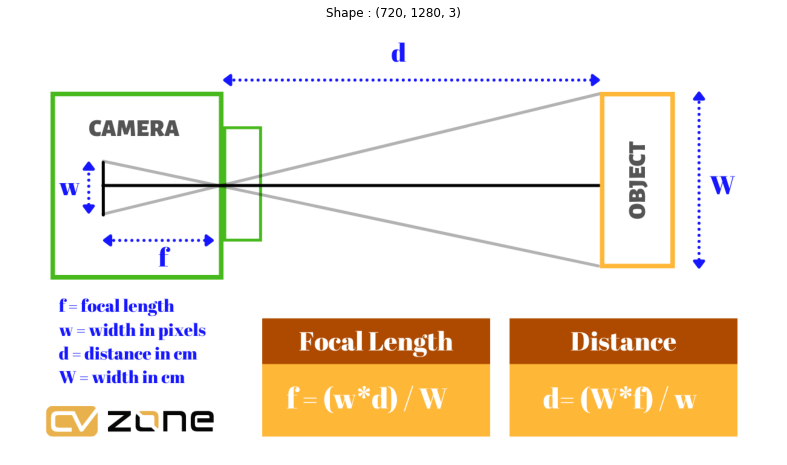

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread("/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/Distance_Measurement.png")

plt.figure(figsize = (15,8))
plt.imshow(img)
plt.axis("off")
plt.title(f"Shape : {img.shape}")
plt.show()

In [19]:
pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps


def putTextRect(image,text,pos,scale = 3,thickness = 3 ,colorT = (255,255,255),
                colorR = (255,0,255),font = cv2.FONT_HERSHEY_PLAIN,
                offset = 10,border = None,colorB = (0,255,0)):
    
    ox,oy = pos
    (w,h),_ = cv2.getTextSize(text,font,scale,thickness)
    x1,y1,x2,y2 = ox - offset , oy +offset, ox+w + offset, oy - h - offset 
    cv2.rectangle(image,(x1,y1),(x2,y2),colorR,cv2.FILLED)
    
    if border is not None:
        cv2.rectangle(image,(x1,x2),(x2,y2),colorR,cv2.FILLED)
    
    cv2.putText(image,text,(ox,oy),font,scale,colorT,thickness)
    return image,[x1,y2,x2,y1]

cap = cv2.VideoCapture(0)
mesh_detector = FaceMeshDetector()
textList = ["Artificial Intelligence",
            "Computer Vision",
            "TensorFlow",
            "PyTorch",
            "Machine Learning"]
sen = 10

while True:

    conn,frame = cap.read()
    imageBlack = np.zeros_like(frame)


    frame,faces = mesh_detector.findFaceMesh(frame,draw = False,id_draw = False)
    
    if faces:
        face = faces[0]
        pointLeft = face[145]
        pointRight = face[374]
        
        cv2.circle(frame,(pointLeft[0],pointLeft[1]),5,(255,0,255),cv2.FILLED)
        cv2.circle(frame,(pointRight[0],pointRight[1]),5,(255,0,255),cv2.FILLED)
        cv2.line(frame,pointLeft,pointRight,(0,200,0),3)
        
        # 2 göz arası uzaklık !!
        w,info = mesh_detector.findDistance(pointLeft,pointRight)
        # Göz Uzunluğu
        W = 6.3
        
        # Focal Length
        
        # Önemli olan nokta uzaklığı ölç kamera ile olan !!!!
        # Sonra f değerini belirle
        
        #d = 45  ### masandan olan uzaklık
        #f = (w*d) / W
        #print(f)
        f = 700
        
        #Distance
        d = (f*W) / w
        #print(d)
        
        putTextRect(frame,f"Depth : {int(d)}cm",(face[10][0]-100,face[10][1]-50),scale = 2)
        
        for i,text in enumerate(textList):
            singleHeight = 20 + int((int(d/sen)*sen)/4)
            scale = 0.7 + (int(d/sen)*sen)/75
            
            cv2.putText(imageBlack,text,(500,100+ (i * singleHeight)),
                        cv2.FONT_ITALIC,scale,(255,255,255),2)
        

        
    stack = np.hstack([frame,imageBlack])
    stack = cv2.resize(stack,(1280,720))
    fps_ = fps()
    cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Frame",stack)
    if cv2.waitKey(1) & 0xff == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

## 

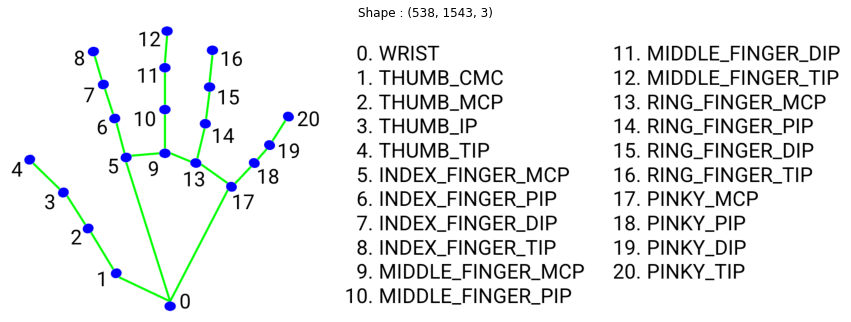

In [22]:
img = cv2.imread("/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/mediapipeHands.png")

plt.figure(figsize = (15,8))
plt.imshow(img)
plt.axis("off")
plt.title(f"Shape : {img.shape}")
plt.show()

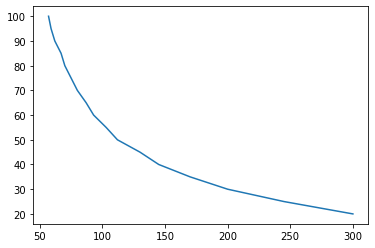

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Find Function
# x is the raw distance y is the value in cm
x = [300, 245, 200, 170, 145, 130, 112, 103, 93, 87, 80, 75, 70, 67, 62, 59, 57]
y = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
plt.plot(x,y);

In [12]:
coff = np.polyfit(x, y, 2)  # y = Ax^2 + Bx + C
coff

array([ 2.01978349e-03, -9.88845583e-01,  1.40539209e+02])

In [25]:
for i in x:
    print(int(coff[0]*(i)**2 + coff[1]*(i) + coff[2]),end = " ")

25 19 23 30 39 46 55 60 66 69 74 77 81 83 86 89 90 

In [3]:
import math
import cv2
import numpy as np
import time
import random

pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

def putTextRect(image,text,pos,scale = 3,thickness = 3 ,colorT = (255,255,255),
                colorR = (255,0,255),font = cv2.FONT_HERSHEY_PLAIN,
                offset = 10,border = None,colorB = (0,255,0)):
    
    ox,oy = pos
    (w,h),_ = cv2.getTextSize(text,font,scale,thickness)
    x1,y1,x2,y2 = ox - offset , oy +offset, ox+w + offset, oy - h - offset 
    
    cv2.rectangle(image,(x1,y1),(x2,y2),colorR,cv2.FILLED)
    
    if border is not None:
        cv2.rectangle(image,(x1,x2),(x2,y2),colorR,cv2.FILLED)
    
    cv2.putText(image,text,(ox,oy),font,scale,colorT,thickness)
    return image,[x1,y2,x2,y1]



# Buradaki amaç şu Elimizi normalde yaklaştırdımığımızda 
# 5 ile 17 ara büyüyor mesafe olarak fakat biz elimizi yaklaştırıp uzaklaştırdığımızda
# Ekran ile olan mesafeyi bulmak istiyoruz 
# Buda bunu sağlayabilicek doğruluk oranı az olsa da Bu denklem ile hesaplayabiliceğimiz bir yöntem !!!1

x = [300, 245, 200, 170, 145, 130, 112, 103, 93, 87, 80, 75, 70, 67, 62, 59, 57]
y = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
# 2.dereceden bir denklem !!!
coff = np.polyfit(x,y,2)

def distance(length):
    return coff[0]*(length)**2 + coff[1]*length + coff[2]

cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

hand_detector = HandDetector(maxHands=1)


# For Gaming

cx,cy = 250,250
color = (255,0,255)
counter = 1
score = 1
timeStart = time.time()
totalTime = 20


while True:
    
    conn,frame = cap.read()
    frame = cv2.flip(frame,1)
    
    if time.time() - timeStart < totalTime:
    
        allhands,frame = hand_detector.findHands(frame,draw = True,flipType = False)

        if allhands:
            lmList = allhands[0]["lmList"]
            bbox = allhands[0]["bbox"]
            x1,y1 = lmList[5][:-1]
            x2,y2 = lmList[17][:-1]

            # Ekrana yaklaştırınca değer artıyor uzaklaşınca azalıyor !!
            # El çevirince dikkat !!!

            length1,info1,frame = hand_detector.findDistance(lmList[5][:-1],lmList[17][:-1],frame)
            #cv2.putText(frame,f"Distance : {int(length1)},xdiff : {int(abs(x2-x1))},ydiff : {int(abs(y2-y1))}",
            #            (20,120),2,cv2.FONT_HERSHEY_PLAIN,(255,0,0),2)

            distanceCm = distance(length1)
            #cv2.putText(frame,f"DistanceCM : {int(distanceCm)}",
            #    (20,120),2,cv2.FONT_HERSHEY_PLAIN,(255,0,0),2)

            putTextRect(frame,f"DistanceCM : {int(distanceCm)}",(bbox[0]-15,bbox[1]-65),scale = 2,thickness=2,
                       colorR=(0,255,0))

            if distanceCm < 40:
            #    if bbox[0] < cx < bbox[0] + bbox[2] and bbox[1] < cy < bbox[1] + bbox[3]:         
            #        color = (0,255,0)
            #else:
            #    color = (255,0,255)
                if bbox[0] < cx < bbox[0] + bbox[2] and bbox[1] < cy < bbox[1] + bbox[3]:  
                    counter = 1


        # Delay !!!
        # Bunu yapmaktaki amaç şu oyunda şu olabilir 40 cm az tutarak score kasabiliriz 
        # Ama biz bunu engellemek için şunu yapıyoruz eğer sen elini 40 cm tutarsan hep counter = 1 olucak hep
        # Ve renk olarak hep yeşil gözükicek çünkü hep 1 dönicek
        # Elimizi çekersek counter +1 olarak artıp 4 olana kadar sayıcak ve renk değişicek
        # Amaç hem trick engellemek ve zaman oluşturmak !!!
        if counter:
            counter+=1
            color = (0,255,0)
            if counter == 4:
                cx = random.randint(100,1100)
                cy = random.randint(100,600)
                color = (255,0,255)
                score +=1
                counter = 0

        # Draw Button
        cv2.circle(frame,(cx,cy),30,color,cv2.FILLED)
        cv2.circle(frame,(cx,cy),10,(255,2555,255),cv2.FILLED)    
        cv2.circle(frame,(cx,cy),20,(255,255,255),2)
        cv2.circle(frame,(cx,cy),30,(50,50,50),2)


        putTextRect(frame,f"Time : {int(totalTime - (time.time() - timeStart))}",
                    (1000,75),scale = 3,offset=25)    
        putTextRect(frame,f"Score : {str(score).zfill(2)}",(50,75),scale = 3,offset=25)
        
    else:
        
        putTextRect(frame,f"Game Over",(400,400),scale = 5,offset=35,thickness=7)
        putTextRect(frame,f"Points : {score}",(500,520),scale = 3,offset=35,thickness=7)
        putTextRect(frame,f"Press R to restart",(470,650),scale = 2,offset=35,thickness=5)
        

    fps_ = fps()
    cv2.putText(frame,f"FPS : {int(fps_)}",(500,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,255),3)
    cv2.imshow("Frame",frame)
    
    if cv2.waitKey(1) == ord("r"):
        timeStart = time.time()
        score = 0
        
    if cv2.waitKey(1) & 0xff==ord("q"):
        break

cap.release()
cv2.destroyAllWindows()